# BBC - Laboratoires 3-4
## Transcriptomique

- Professeur: Carlos Peña (<a href="mailto:carlos.pena@heig-vd.ch">carlos.pena@heig-vd.ch</a>)
- Assistant: Brochet Xavier (<a href="mailto:xavier.brochet@heig-vd.ch">xavier.brochet@heig-vd.ch</a>)

Date: Printemps 2020

> ## Objectifs pédagogiques
Pour réaliser ce laboratoire, du vocabulaire et des notions de base en biologie seront introduits ou perfectionnés. A la fin du laboratoire, l’étudiant devrait:
- Comprendre le type d'informations contenues dans les puces à ADN (microarray ou DNA chip en anglais)
- Savoir identifier des gènes exprimés differentiellement dans une condition vs. une autre (malade vs. sain)
- Comprendre les notions de test statistique et de p-valeur
- Comprendre comment l'apprentissage automatique peut être utilisé pour prédire si un patient est malade ou pas.
- Connaître l'existence de plusieurs technologies de type "omique".


> ## But du labo
La leucémie aiguë myéloblastique (AML) est un cancer qui touche les globules blancs du sang. On souhaite développer un médicament contre ce cancer, en identifiant des gènes qui sont particulièrement sur-exprimés (ou sous-exprimés) dans les cellules cancéreuses, comparé aux cellules normales. En effet, ces gènes seraient de bons candidats à cibler par le médicament. Une équipe de biologistes de Seattle (USA) a donc décidé d'utiliser la technologie des puces à ADN pour mesurer l'expression de 22283 gènes humains dans des cellules normales et des cellules leucémiques (PMID: <a href="http://www.ncbi.nlm.nih.gov/pubmed/17910043">17910043</a>). Grâce à ce set de données, votre but est, dans un premier temps, d'identifier quelques gènes candidats pour développer un médicament contre ce cancer. Dans un deuxième temps, vous utiliserez ces même données comme un outil de diagnostique pour savoir si un patient est atteint d'AML ou pas.

> <b>→ Téléchargez l'article sur la page dédié au labo sur Cyberlearn. </b><!-- l'<a href="https://drive.switch.ch/public.php?service=files&t=852287bdefda93c6f0966ee988183e1f">article</a> ainsi que les  <a href="https://drive.switch.ch/public.php?service=files&t=5c89d25388c7d122fac6e967b9c781b0">données associées (.zip)</a>. </b> -->
> ## Démarche
1. Visualiser quelques données pour mieux comprendre le problème.
2. Cibles thérapeutiques: (a) Identifier des gènes candidats à l'aide de la corrélation. (b) Améliorer la liste obtenue à l'aide du t-test et visualiser la matrice des candidats finaux.
3. Construire un classificateur pour développer un outil diagnostique.


> ## Rapport de labo

> <p >Merci de répondre aux questions posées sur fond cyan de façon concise dans la cellule située <u>juste en dessous</u>, et de nous retourner ce notebook.
> <p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>0. </b></font> Ceci est une question.</p>

## 1. Les données - mieux comprendre le problème

Pour information, le set de données a été téléchargé à partir du <a href="http://www.ncbi.nlm.nih.gov/sites/GDSbrowser?acc=GDS3057">site du NCBI</a> (curated dataset browser), qui est très utile pour faire des recherches de données en fonction d'une thématique. Comme vu lors des précédents laboratoires, vous pouvez également accéder à cette base de données en ligne de commande en utilisant "Entrez Direct".

<b>→ A l'aide de votre tableur préféré (Excel,...), ouvrez le fichier GDS3057.soft et inspectez-le.</b>

De nombreuses informations sur le set de données commencent par le caractère "!". Puis chaque condition (type de cellules, cancéreuses ou pas) est décrite à partir du caractère "#". Les données d'expression des gènes commencent après le tag "!dataset_table_begin": chaque ligne correspond à un gène, et les colonnes représentent l'expression de ce gène dans différents types de cellules (=conditions) testés ici.

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>1.1 </b></font>A quel type de cellules (leucémie ou normal) correspond la condition GSM239487?</p>

D'après la liste des conditions, la condition GSM239497 est de type leucémie (src: Leukemia).

Par la suite, vous utiliserez python pour lire les données et les analyser.

<b>→ Commencez par importer les modules suivants</b>

> En cas de soucis d'encodage, ajoutez les lignes suivantes à ~./bash_profile et re-lancez ipython notebook:
> <p>export LC_ALL=en_US.UTF-8</p>
> export LANG=en_US.UTF-8

In [1]:
import os
import numpy as np
import pylab as plt
%matplotlib inline
import pandas as pd

<b>→ Importez les données grâce au module Geo (Gene Expression Omnibus) de biopython</b>

In [2]:
import numpy as np
from Bio import Geo

def load_geo(myfile):
    handle = open(myfile)
    records = Geo.parse(handle)
    return records
    
records = load_geo('GDS3057.soft')

<b>→ Exécutez plusieurs fois d'affilée la commande ci-dessous, afin de mieux comprendre ce que contient records.</b> (Arrêtez-vous seulement lors de l'erreur "StopIteration")

In [12]:
nr = next(records)
print(nr)
print('\n---------------------- ENTITY_ATTRIBUTES:------------------------------\n')
print(nr.entity_attributes)

StopIteration: 

A présent que vous savez ce que contient records, vous allez le "parser" pour trouver une description de chaque condition et extraire les données.

<b>→ Testez les attributs de records pour trouver les conditions associées à chaque type cellulaire, ainsi que les conditions associées aux cellules cancéreuses.</b>

In [13]:
# start by re-loading the data
records = load_geo('GDS3057.soft')

# description of each condition (cell type)
id_cond = {}  

# loop over records
for r in records:    
    
    rea = r.entity_attributes
    
    if 'subset_sample_id' in rea:
        
        # find conditions associated with each cell type
        if rea['subset_type']=='cell type':
            sample_list = rea['subset_sample_id'].split(',')
            desc = rea['subset_description']
            for sample in sample_list:
                id_cond[sample] = desc     
        
        # find conditions associated with the disease
        if (rea['subset_type']=='disease state') & (rea['subset_description']=='leukemia'):
            leukemia_list = rea['subset_sample_id'].split(',')

    if 'dataset_table_begin' in rea:
        data = r.table_rows

# converts data to an array (more practical to handle)
data = np.array(data)

La dernière commande, data = np.array(data), convertit la variable data en un tableau à deux dimensions. Pour accéder à l'élément correspondant à la 3ème ligne et 5ème colonne, vous devez écrire data[3,5]. L'avantage par rapport aux listes de listes, c'est que vous pouvez facilement sélectionner une colonne ou une ligne de data. <a href="http://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html">Plus d'info sur les arrays multidimensionnels ici.</a>

<b>→ Imprimez des éléments de data pour bien saisir ce qu'est un array.</b> 

In [14]:
print(data[3,5]) # élément de data à l'intersection de la 3ème ligne et 5ème colonne
print(data[4,:]) # ligne 4 de data = un gène en particulier
print(data[:,7]) # colonne 7 de data = une condition en particulier !! imprimée sur une ligne, mais c'est une colonne !!

4.49776
['121_at' 'PAX8' '7.62111' '7.0994' '7.94294' '7.60755' '7.90653'
 '6.80387' '7.74351' '7.47744' '7.53575' '7.68504' '7.49126' '7.76188'
 '7.35098' '7.57658' '7.09422' '7.29822' '7.1497' '7.20392' '7.63824'
 '7.49124' '8.22107' '7.46194' '7.07908' '6.66564' '7.55594' '7.22986'
 '7.42081' '6.99934' '7.09449' '7.02433' '7.17929' '7.1599' '7.00998'
 '6.83098' '7.20862' '7.21843' '6.9481' '6.77158' '6.83915' '6.99341'
 '7.14967' '7.15619' '6.95498' '6.81985' '6.82583' '7.2438' '7.25609'
 '7.30733' '7.29586' '7.45747' '7.63463' '7.6154' '8.01982' '7.52725'
 '7.55083' '7.28955' '6.93698' '7.13647' '7.13442' '7.28159' '7.10976'
 '7.11019' '7.09445' '7.09615']
['GSM239520' '2.73863' '6.81105' ... '2.65068' '2.14404' '2.85576']


<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>1.2 </b></font>Quelle commande devez-vous écrire pour afficher la liste des ID_REF? Et la liste des IDENTIFIER?</p>

In [19]:
print("Liste des ID_REF : ")
print(data[:,0])
print("\nListe des IDENTIFIER : ")
print(data[:,1])

Liste des ID_REF : 
['ID_REF' '1007_s_at' '1053_at' ... 'AFFX-TrpnX-3_at' 'AFFX-TrpnX-5_at'
 'AFFX-TrpnX-M_at']

Liste des IDENTIFIER : 
['IDENTIFIER' 'DDR1' 'RFC2' ... '--Control' '--Control' '--Control']


<b>→ A présent, visualisez id_cond </b>

In [20]:
id_cond

{'GSM239323': 'bone marrow',
 'GSM239324': 'bone marrow',
 'GSM239326': 'bone marrow',
 'GSM239328': 'bone marrow',
 'GSM239329': 'bone marrow',
 'GSM239331': 'bone marrow',
 'GSM239332': 'bone marrow',
 'GSM239333': 'bone marrow',
 'GSM239334': 'bone marrow',
 'GSM239335': 'bone marrow',
 'GSM239371': 'bone marrow',
 'GSM239487': 'bone marrow',
 'GSM239489': 'bone marrow',
 'GSM239492': 'bone marrow',
 'GSM239497': 'bone marrow',
 'GSM239520': 'bone marrow',
 'GSM240427': 'bone marrow',
 'GSM240430': 'peripheral blood',
 'GSM240431': 'peripheral blood',
 'GSM240432': 'peripheral blood',
 'GSM240433': 'peripheral blood',
 'GSM240494': 'peripheral blood',
 'GSM240495': 'peripheral blood',
 'GSM240496': 'peripheral blood',
 'GSM240497': 'peripheral blood',
 'GSM240498': 'peripheral blood',
 'GSM240499': 'peripheral blood',
 'GSM239516': 'peripheral blood',
 'GSM239345': 'peripheral blood',
 'GSM239346': 'peripheral blood',
 'GSM239348': 'peripheral blood',
 'GSM239363': 'peripheral blood

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>1.3 </b></font>
Pour faciliter l'analyse des données par la suite, remplacez dans id_cond les conditions qui correspondent à des cellules cancéreuses par "AML"
<p>

In [22]:
new_label = 'AML'

for l in leukemia_list:
    id_cond[l] = new_label

<b>→ Les préparatifs sont presque prêts: divisez votre set de données en "train" et "test" sets, afin de pouvoir valider la performance de vos prédictions par la suite.</b>

In [23]:
# divide the set into two sets: a train set and a test set for future validations
idx_test = [5,11,19,28,54,61]
idx_train = list(range(0,len(id_cond)+2))
[idx_train.remove(i) for i in idx_test]

data_test = data[:,idx_test]
data = data[:,idx_train]

print(np.shape(data))
print(np.shape(data_test))

(22284, 60)
(22284, 6)


<b>→ Finalement, afin de mieux visualiser les données par la suite, ordonnez-les en fonction du type cellulaire et associez une couleur à chaque type cellulaire</b>

In [24]:
# cell types
cell_type = list(set(id_cond.values())) 
print('cell_type:\t\t'+str(cell_type))

# order cell_type so that AML (= leukemia = cancer cells) appears at the end
cell_type.remove('AML')
cell_type.append('AML')
print('\nre-ordered cell_type:\t'+str(cell_type))

# idx_cell_type will be used to re-order the columns of data as a function of cell_type
idx_cell_type = [0,1] # we don't want to re-order the first two columns (= gene name and identifier)

# colors will be used when plotting the data (each cell type has a corresponding color)
unique_colors = ['c','g','r','b','k']
colors_cell_type = [] 

# for every type in cell_type, find the corresponding colums in data and add them to idx_cell_type
for j,ct in enumerate(cell_type):
    elements_cell_type = [ i+2 for i,c in enumerate(data[0,2:]) if id_cond[c]==ct]
    idx_cell_type.extend(elements_cell_type)
    colors_cell_type.extend(unique_colors[j]*len(elements_cell_type))
print('\nidx_cell_type:\t'+str(idx_cell_type))    
print('\ncolors_cell_type:\t'+str(colors_cell_type))

# re-order columns of data (= conditions) with idx_cell_type
data = data[:,idx_cell_type]

cell_type:		['AML', 'peripheral blood', 'PBSC CD34plus', 'bone marrow', 'bone marrow CD34plus']

re-ordered cell_type:	['peripheral blood', 'PBSC CD34plus', 'bone marrow', 'bone marrow CD34plus', 'AML']

idx_cell_type:	[0, 1, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 51, 52, 53, 54, 55, 56, 57, 58, 59, 25, 26, 27, 28, 29, 30, 31, 32, 33, 44, 45, 46, 47, 48, 49, 50, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

colors_cell_type:	['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k']


<b>→ Visualisez l'expression du gène PBX1 (212148_at) sur toutes les conditions, colorées en fonction du type cellulaire:</b>

11534

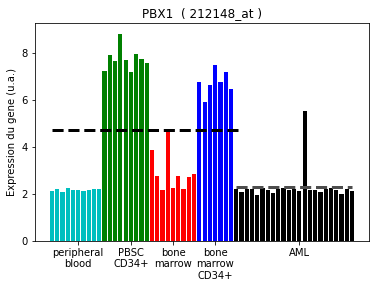

In [25]:
def mean_expression_leukemia_normal(data,colors_cell_type):
    
    data_leukemia = [float(data[i]) for i,c in enumerate(colors_cell_type) if c=='k']
    data_normal = [float(data[i]) for i,c in enumerate(colors_cell_type) if c!='k']
    
    return (np.nanmean(data_normal),np.nanmean(data_leukemia))

def plot_gene_expression_across_conditions(data,gene,cell_type,colors_cell_type):
    
    # find the line in data corresponding to our gene of interest and get the gene expression levels
    idx_gene = [i for i,x in enumerate(data[:,0]) if x==gene][0]
    data_to_show = (data[idx_gene,2:]).tolist() # remove the first two elements corresponding to gene name and identifier
    data_to_show = np.array(data_to_show,dtype=float) # convert to float
    
    # plot the data
    fig, ax = plt.subplots()
    plt.bar(range(0,len(data_to_show)),data_to_show,color=colors_cell_type)
    plt.title(data[idx_gene,1]+'  ( '+data[idx_gene,0]+' )')
    ax.set_xticks([5,15,23,31,47])
    ax.set_xticklabels([ct.replace(' ','\n').replace('plus','+') for ct in cell_type])
    ax.set_ylabel('Expression du gene (u.a.)')

    # represent the mean gene expression in normal and cancer cells with a dashed line
    (mean_normal, mean_leukemia) = mean_expression_leukemia_normal(data_to_show,colors_cell_type)
    plt.hlines(mean_leukemia,35,57,linestyles='--',color=[0.3,0.3,0.3],lw=3) # draw a line to show mean(expression of cancer cells)
    plt.hlines(mean_normal,0,36,linestyles='--',lw=3) # draw a line to show mean(expression of normal cells)
    
    return idx_gene

# gene of interest
gene = '212148_at' 
#gene = '206067_s_at' 
plot_gene_expression_across_conditions(data,gene,cell_type,colors_cell_type)

Vous pouvez observer que l'expression du gène PBX1 est en moyenne plus élevée dans les cellules normales (en couleur, environ 5[a.u.]) que dans les cellules cancéreuses (AML, en noir, environ 2[a.u.]).
<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>1.4 </b></font>
<b>(a)</b> A vue d'oeil,est-ce que l'expression du gène PBX1 est significativement différente dans les cellules cancéreuses (AML, en noir) vs. les cellules normales du type "peripheral blood" (en bleue)? 
<p>
<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>1.4 </b></font>
<b>(b)</b> A votre avis, si un médicament parvenait à augmenter l'expression du gène PBX1 dans les cellules cancéreuses à une valeur d'environ 5[u.a], est-ce qu'on serait en droit de penser que ces cellules sont à présent plus "normales"? Justifiez brièvement.
</p>
<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>1.4 </b></font>
<b>(c)</b> Par conséquent, est-ce qu'un test statistique basé sur la comparaison de l'expression moyenne d'un gène dans les cellules cancéreuses vs. dans les cellules normales (tous types cellulaires confondus) serait une bonne approche pour identifier un gène candidat comme cible d'un médicament? Justifiez brièvement.
</p>

<p> <b>(a)</b>  
À vue d'oeil, l'expression du gène est globalement la même dans les cellules cancéreuses et dans les cellules "peripheral blood". La médiane se situe aux alentours de 2[a.u.].
</p>

<p><b>(b)</b> 
Selon nous, il n'y a pas de corrélation entre l'expression du gène et le fait d'être une cellule cancéreuse ou non. Comme on peut le voir avec les cellules "periphal blood", avoir une médiane à 5[a.u.] ne suffit pas à être sain. De plus, bien que la médiane se trouve à 5[a.u.], aucun type de cellule particulier ne se situe lui à 5[a.u.].
</p>

<p><b>(c)</b>
Si un test statistique se base uniquement sur la comparaison de l'expression moyenne d'un gène, cela ne sera pas forcément concluant. Par contre, ces statistiques peuvent fournir certaines caractéristiques de cellules cancéreuses.
</p>

<b>→A présent, visualisez l'expression du gène 206067_s_at</b>
<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>1.5 </b></font>
Est-ce que le gène WT1 serait un meilleur candidat que PBX1 comme cible d'un médicament? Justifiez brièvement.
<p>

5593

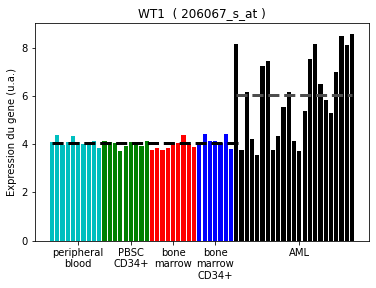

In [26]:
# gene of interest
gene = '206067_s_at' 
plot_gene_expression_across_conditions(data,gene,cell_type,colors_cell_type)

Oui, s'il était possible de diminuer l'expression du gène WT1 dans les cellules cancéreuse à l'aide d'un médicament, alors les résultats seraient probablement plus probants (toutes les autres expressions du gène se trouvent dans les mêmes valeurs, contrairement au gène PBX1). 

## 2a. Cibles thérapeutiques: Identifier des gènes candidats à l'aide de la corrélation

Dans cette partie, vous allez identifier des gènes exprimés différentiellement dans les cellules cancéreuses versus les cellules normales (tous types confondus) à l'aide de la corrélation. 

<b>→ Pour cela, vous allez comparer l'expression de chaque gène avec celle du profil d'expression "desired_profile":</b>

In [27]:
desired_profile = [1 if id_cond[s]=='AML' else 0 for s in data[0,2:]]
print('desired_profile = '+str(desired_profile))

desired_profile = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


<b>→ Représentez graphiquement desired_profile.</b>

4182

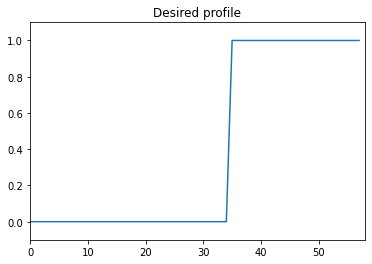

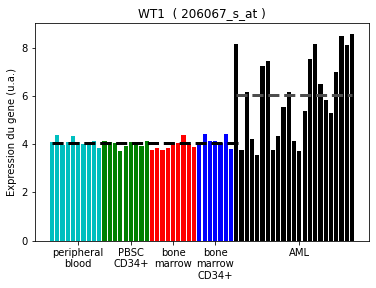

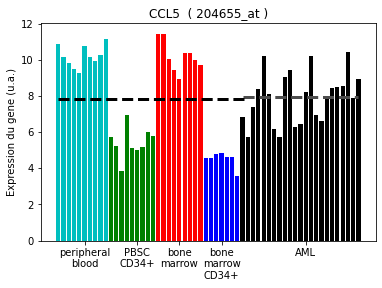

In [28]:
fig = plt.figure()

# plot desired_profile
plt.plot(desired_profile)
plt.ylim([-0.1,1.1])
plt.xlim([0,len(desired_profile)])
plt.title('Desired profile')

# plot also gene expression data for a couple of genes to compare with desired_profile
plot_gene_expression_across_conditions(data,'206067_s_at',cell_type,colors_cell_type)
plot_gene_expression_across_conditions(data,'204655_at',cell_type, colors_cell_type)

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>2.1 </b></font>
A votre avis, est-ce que l'expression du gène WT1 sera significativement corrélée avec desired_profile? Et l'expression du gène CCL5? (Justifiez brièvement)
<p>

Comme la corrélation représente la similarité entre deux courbes, WT1 sera significativement corrélée avec desired_profile, alors que CCLD5 beaucoup moins.

Afin de formaliser cette "similarité", vous allez utiliser la <a href="https://en.wikipedia.org/wiki/Correlation_and_dependence">corrélation de Pearson</a> (une valeur proche de 1 signifie que les variables sont très corrélées, une valeur proche de -1 que les valeurs sont inversément corrélées, et une valeur autour de zéro que les variables ne sont pas corrélées).

<b>→ Calculez la corrélation de Pearson pour chaque gène présent dans le set de données et faites une représentation graphique.</b>

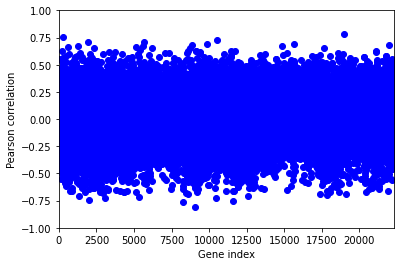

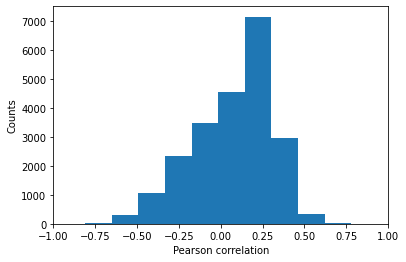

In [29]:
def pearson_genes(data,desired_profile,show_plot=1):

    import scipy.stats as ss

    correl = [] # contains the correlation for each gene
    correl_p  = [] # for now, do not try to understand what correl_p is...
    
    # loop over genes
    for i in range(np.shape(data)[0]-1): # do not consider first line of data (=header)
        
        gene_expression = data[i+1,2:] # do not consider first two columns (= gene identifiers)
        gene_expression = np.array(gene_expression,dtype=float) # convert to float
        
        pearson_corr = ss.pearsonr(gene_expression,desired_profile) # calculate Pearson correlation
        correl.append(pearson_corr[0])
        correl_p.append(pearson_corr[1]) # forget about this for now...
        
    correl = np.array(correl,dtype=float) # convert to array... easier to manipulate
    
    # plot correlation values
    if show_plot:
        fig = plt.figure()
        plt.plot(correl,'bo')
        plt.ylim([-1,1])
        plt.xlim([0,len(correl)])
        plt.xlabel('Gene index')
        plt.ylabel('Pearson correlation')
        plt.show()
        
        plt.figure()
        plt.hist(correl)
        plt.xlabel('Pearson correlation')
        plt.ylabel('Counts')
        plt.xlim([-1,1])
        plt.show()

    return (correl,correl_p)

co = pearson_genes(data,desired_profile)
corr = co[0]

Comme vous le voyez, les valeurs de corrélation sont comprises entre [-1,1], avec une plus grosse densité autour de zéro. L'histogramme vous permet même de voir plus précisément qu'en fait, la majorité des valeurs de corrélation sont plutôt autour de 0.2. 

A présent, votre but est d'identifier les gènes qui sont <i><b>significativement</b></i> corrélés (ou inversément corrélés) avec desired_profile. Une approche naïve consisterait à trier les gènes en fonction de leur corrélation pour ne garder que les "meilleurs". Se pose alors une question: combien de gènes garde-t-on? Doit-on éliminer tous ceux dont la valeur absolue de corrélation est plus petite que 0.5? Ou 0.75? Comment décider du seuil? 

Afin de résoudre ce problème, posez-vous la question suivante: si notre set de données ne contenait <i>aucune</i> information, quelles valeurs de corrélation s'attendrait-on à obtenir? Naïvement, on pourrait penser que la corrélation serait toujours nulle. En réalité, elle sera <i> majoritairement </i> nulle, mais parfois, par pur hasard, même une assez grande valeur de corrélation pourrait être obtenue.

Pour le vérifier, vous allez randomiser les colonnes du set de données et voir quelles valeurs de corrélation seraient obtenues dans ce cas. Par randomisation des colonnes, on veut dire qu'une condition qui était préalablement labélisée "AML" pourrait maintenant être labélisée "bone marrow" à la place. Par conséquent, on s'attend à ce que les mesures de corrélation soient bien plus mauvaises avec ces données randomisées... puisque l'information utile a été randomisée. 

Si jamais vous observiez que la distribution des corrélations randomisée est très similaire à la distribution des corrélations non-randomisées, c'est que le set de données ne contient pas plus d'information que du bruit! 

<b>→ Commencez par générer des données randomisées à partir de notre set de données</b>

In [32]:
def shuffle_data(data):
    
    from random import shuffle
    
    # get shuffled columns indexes
    shuffled_idx = list(range(2,np.shape(data)[1])) # ! do not shuffle the first two colums (= gene identifiers)
    shuffle(shuffled_idx) # shuffled_idx is now shuffled
    shuffled_idx.insert(0,0)
    shuffled_idx.insert(1,1)

    # use shuffled_idx to randomize the columns of data
    data_random = data[:,shuffled_idx]
    data_random[0,:] = data[0,:] # put label conditons on top again

    return data_random
    
data_random = shuffle_data(data)
print(str(data[3,0:5])+' = un gène NON randomisé')
print(str(data_random[3,0:5])+' = le même gène avec les conditions randomisées')

['117_at' 'HSPA6' '9.27585' '9.12669' '9.18116'] = un gène NON randomisé
['117_at' 'HSPA6' '4.66417' '4.88442' '4.32786'] = le même gène avec les conditions randomisées


<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>2.2 </b></font>
A l'aide de la fonction plt.hist(), comparez la distribution des corrélations dans le set randomisé vs. non-randomisé. Astuce: représentez les deux distributions sur le même graphique, avec des couleurs différentes.
<p>

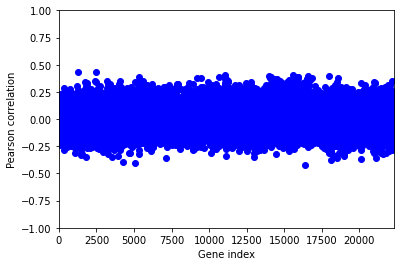

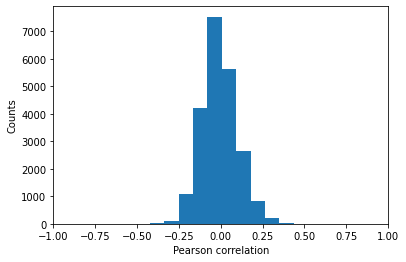

In [33]:
co = pearson_genes(data_random,desired_profile)

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>2.3 </b></font>
A votre avis, est-ce que le set de données contient de l'information? Justifiez brièvement.
<p>

Oui, on peut le voir grâce aux valeurs des graphes. Elles sont beaucoup plus centrée autour du 0 avec des valeurs aléatoires, et légèrement plus symétrique.

Et maintenant? Pour chaque gène, vous avez une valeur de corrélation "observée (réelle)" et une valeur de corrélation "random". Vous pourriez donc être tenté de comparer ces deux valeurs pour ne garder que les gènes qui ont une valeur de corrélation observée plus grande que la valeur random... Mais ceci reviendrait à supposer que la valeur de corrélation random est fixée une fois pour toutes... alors qu'en fait, à chaque fois que vous allez randomiser le set de données, vous allez trouver une autre valeur de corrélation random pour chaque gène. Afin de faire des comparaisons qui aient du sens, il faudrait donc connaître, pour chaque gène, la distribution des valeurs de corrélation random, et comparer la valeur de corrélation réelle à cette distribution.

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>2.4 </b></font>
Répétez la randomisation 10 fois: à chaque fois, calculez la corrélation à l'aide de la fonction pearson_corr().
<p>

In [36]:
for i in range(10):
    data_random = shuffle_data(data)
    print(i,pearson_genes(data_random,desired_profile,0)[0])

0 [-0.00521291  0.08155259 -0.14626625 ...  0.0402986   0.07782321
  0.04660556]
1 [0.17553143 0.10460219 0.08139142 ... 0.15181702 0.16354352 0.18529625]
2 [-0.1366198  -0.14812579  0.12491947 ... -0.09375404 -0.08509092
 -0.05658339]
3 [ 0.01213831 -0.37353294  0.09304614 ...  0.24316113  0.22064079
  0.28265685]
4 [ 0.18343974 -0.29207621  0.32163381 ...  0.10784196  0.10759604
  0.07270684]
5 [ 0.25381575 -0.12793315 -0.19507337 ... -0.01294297 -0.02605027
  0.01137963]
6 [-0.01618047  0.17624709  0.15012149 ... -0.20867358 -0.19682356
 -0.17704471]
7 [ 0.05009389 -0.10513643 -0.24021531 ... -0.15798166 -0.12303402
 -0.18234472]
8 [ 0.00731576 -0.12778256 -0.07796939 ... -0.09710773 -0.06031855
 -0.10159855]
9 [-0.11722024 -0.01048029  0.13708824 ... -0.1380564  -0.14942962
 -0.03277822]


<b>→ Pour quelques gènes, représentez graphiquement la distribution des corrélations random ainsi que la valeur observée (le fichier random_correlation.npy contient des valeurs de corrélation obtenues en randomisant 1000 fois le set de données) </b>

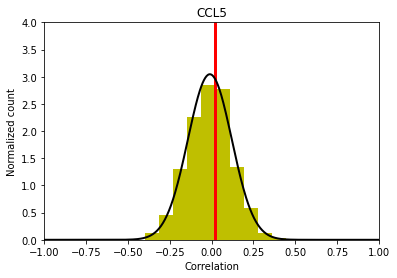

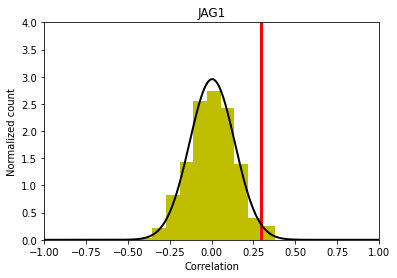

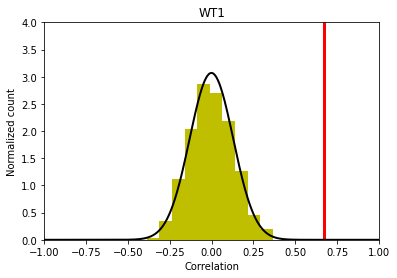

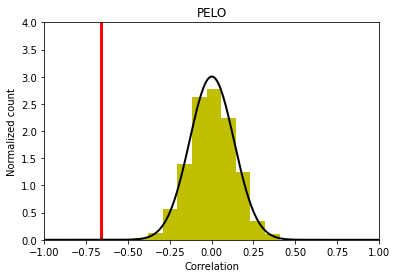

In [38]:
from scipy.stats import norm

# load correlations from 1000 runs of randomized data
corr_random = np.load('random_correlations.npy') 

# show results only for these genes
idx_genes_to_show = [4181,8590,5592,17836] 

# plot: loop over idx_genes_to_show
for idx in idx_genes_to_show: 
    fig = plt.figure()
    random_correlations = corr_random[idx,:]
    #plt.hist(random_correlations,normed=True,color='w') # ,normed=True # histogramme des valeurs de corrélation obtenues à partir des données randomisées
    plt.hist(random_correlations,density=1,color='y')
    
    plt.vlines(corr[idx],0,4,'r',lw=3) # valeur observée = ligne verticale rouge
    plt.title(data[idx+1,1]) # nom du gène
    plt.xlim([-1,1])
    plt.ylim([0, 4])
    plt.xlabel('Correlation')
    plt.ylabel('Normalized count')
    
    # fit gaussian to distribution of correlations from randomized data
    xx = np.linspace(-1,1,500)
    mu = np.mean(random_correlations)
    sigma = np.std(random_correlations)
    plt.plot(xx,norm.pdf(xx,loc=mu,scale=sigma),'k-',lw=2)

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>2.5 </b></font>
Pour chaque gène, discutez si la valeur de corrélation obtenue semble significativement différente des valeurs obtenues en randomisant les données. 
<p>

Votre réponse...

Afin de quantifier à quel point la corrélation observée est différente de la distribution des corrélations obtenue en randomisant les données, vous allez calculez la p-valeur de la corrélation observée pour chaque gène. La p-valeur est la probabilité d'obtenir, par hasard, une valeur absolue de corrélation au moins aussi grande.

<b>→ Pour chaque gène, calculez la probabilité d'obtenir par hasard une valeur de corrélation aussi grande (ou plus) que la valeur absolue observée.</b> Pour vous aider à mieux comprendre ce concept, le script ci-dessous représente graphiquement la p-valeur (aire sous la courbe hachurée en noir) pour le premier gène.

In [ ]:
N_genes = np.shape(data)[0]-1 # number of genes in the data

pval_correl = [] # p-values 
for idx in range(0,N_genes):
    
    # random correlation: calculate mean and standard deviation
    random_correlations = corr_random[idx,:]
    mean_random = np.mean(random_correlations)
    std_random = np.std(random_correlations)
    
    # observed correlation
    observed_correlation = corr[idx]
    
    # cdf: cumulative distribution function = integral of the gaussian distribution from -inf to observed_correlation
    cdf = norm.cdf(observed_correlation,loc=mean_random,scale=std_random)
    if cdf >= 0.5:
        p = 1 - cdf
    else:
        p = cdf
    pval_correl.append(2*p) # factor 2 because correlations can take both positive and negative values
    
    # show p-value visually for the first gene (p-value = area of black hatched regions under the curve)
    if idx==0:
        plt.figure()
        plt.plot(xx,norm.pdf(xx,loc=mean_random,scale=std_random),'k-',lw=2)
        plt.vlines(corr[idx],0,4 ,'r',lw=2)
        for j in np.linspace(observed_correlation,1,int(100*(1-observed_correlation))):
            plt.vlines(j,0,norm.pdf(j,loc=mean_random,scale=std_random),'k',lw=1)
        for j in np.linspace(-1,-observed_correlation,int(100*(1-observed_correlation))):
            plt.vlines(j,0,norm.pdf(j,loc=mean_random,scale=std_random),'k',lw=1)
        plt.xlabel('Correlation')
        plt.ylabel('Normalized count')
        plt.show()

Les gènes qui nous intéressent sont ceux pour lesquels la p-valeur est très petite. Mais qu'est-ce qu'une "petite" p-valeur? Prenons par exemple un gène qui aurait une p-valeur de 0.05. Dans notre cas, cela signifie que la probabilité que ce gène ait, <i>par hasard</i>, une valeur absolue de corrélation au moins aussi grande est égale à 5% (5%=5/100=0.05). En sciences de la vie et en médecine, il est communément admis qu'une p-valeur inférieure à 0.05 est significative... Qu'est-ce que cela signifierait dans notre cas?

Dans notre cas, nous sommes en train d'effectuer 22283 tests (un test pour chaque gène). Si l'on garde un seuil pour la p-valeur de 0.05, cela représente potentiellement 1114 gènes qui pourraient avoir une p-valeur significative par pur hasard (puisqu'en tirant des valeurs de corrélation au hasard, 5% de ces valeurs seront au moins aussi grandes que la valeur de corrélation observée)! Dans le cas de tests multiples, il est donc nécessaire d'abaisser le seuil de p-valeur... Reste à savoir de combien...

<b>→ Pour vous faire une idée, représentez graphiquement vos p-valeurs à l'aide d'un <a href="https://en.wikipedia.org/wiki/Volcano_plot_(statistics)">"Volcano plot"</a>.</b>

Notez que par commodité, on utilise souvent -log10(p-valeur) pour représenter les p-valeurs. Dans ce cas, 
> si p-valeur=10^[-21], alors

> -log10(p-valeur)=21.

Ce qui revient à dire que dans cette notation, les gènes les plus importants sont ceux dont le -log10(p-val) est le plus grand... Attention aux confusions!

In [ ]:
import stats
stats.volcano_plot(data[1:,2:],desired_profile,pval=pval_correl)

Dans cette représentation, chaque point bleu est un gène. Les gènes intéressants sont ceux qui sont dans les "coins" supérieurs droit et gauche, c'est-à-dire les gènes qui ont une p-valeur très petite, et pour lequel le ratio "expression du gène dans les cellules cancéreuses SUR expression du gène dans les cellules normales" est grand. 

Sur ce plot, une ligne horizontale est également dessinée en traitillé: c'est le seuil qui a été calculé pour la significance, ce qui signifie que seuls les gènes au-dessus de la ligne ont une p-valeur suffisamment petite.

Comment ce seuil a-t-il été calculé? Il existe plusieurs méthodes pour abaisser ce seuil, plus ou moins conservatives. La méthode de Bonferroni, très conservative, détermine le seuil de probabilité pour lequel au moins un faux positif sera identifié. Seules les p-valeurs inférieures à ce seuil sont admises. D'autres méthodes préfèrent contrôler la proportion de faux positifs qui sont admis (<a href="https://en.wikipedia.org/wiki/False_discovery_rate">FDR correction</a>). C'est la méthode qui a été utilisée ici.

<b>→ Identifiez les gènes pour lesquels: -log10(p-valeur) > 4.11 (équivalent à un FDR de 5%, i.e. parmi les gènes identifiés comme significatifs, seuls 5% d'entre eux risquent d'être de faux positifs). </b>

In [ ]:
# Multiple-testing-corrected p-value
fdr_pval = stats.fdr_correction(pval_correl)
print('-log10(p-value FDR) = '+str(-np.log10(fdr_pval))+'\n')

# idx of genes with p-value < fdr_pval
idx_sg_corr = np.array([i for i,p in enumerate(pval_correl) if p<fdr_pval])

# Volcano plot that shows significant genes in red
stats.volcano_plot(data[1:,2:],desired_profile,pval=pval_correl,idx=idx_sg_corr)

# print name of most significant genes
print(str(len(idx_sg_corr))+' significant genes found with correlation (after p-value correction): \n'+str(data[idx_sg_corr+1,1]))

<b>→ Utilisez un heatmap pour visualiser l'expression de ces gènes.</b> Notez que pour la visualisation, les gènes sont aussi regroupés en fonction de leur similarité (clustering hiérarchique, voir dendrogram sur la gauche).

In [ ]:
import matplotlib
import scipy.cluster.hierarchy as cl
import scipy.spatial.distance as ssd

def show_matrix_expression(data,idx_genes,id_cond,dim=(16,10),show_ylabels=True):
    
    # data: matrix of data with headers
    # idx_genes: idx of genes 
    
    if isinstance(idx_genes,list):
        idx_genes = np.array(idx_genes,dtype=int)
    
    conditions = data[0,2:]
    genes = data[:,1]
    data_to_show = data[idx_genes+1,2:]
    
    # re-order genes using hierarchical clustering
    fig = plt.figure(num=None,figsize=(dim),dpi=250) 
    ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
    dmat = ssd.pdist(data_to_show,'cosine')
    Z = cl.linkage(ssd.squareform(dmat),method='average',metric='cosine')
    Z = cl.dendrogram(Z,orientation='left',no_labels=True)
    idx_reorder = Z['leaves']
    data_to_show = data_to_show[idx_reorder,:]    
    
    # plot heatmap
    ax = fig.add_axes([0.3,0.1,0.6,0.6])    
    data_to_show = data_to_show.astype(float)
    heatmap = ax.pcolor(data_to_show, cmap=plt.cm.YlGnBu,vmin=0,vmax=12)
    
    ## pour faire joli...............................................................................
    
    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(data_to_show.shape[1])+0.5, minor=False)
    ax.set_yticks(np.arange(data_to_show.shape[0])+0.5, minor=False)

    # frame and labels position...
    ax.set_frame_on(False)
    ax.xaxis.tick_top()
    ax.grid(False)
    plt.xlim([0,np.shape(data_to_show)[1]])
    plt.ylim([0,np.shape(data_to_show)[0]])

    # set xlabels and ylabels
    if show_ylabels:
        ax.set_yticklabels([genes[ii+1] for ii in idx_genes], minor=False) 
    else:
        ax.yaxis.tick_right()
        ax.set_yticklabels([genes[ii+1] for ii in idx_genes])
    conditions = [id_cond[s] for s in conditions]
    ax.set_xticklabels(conditions, minor=False)

    # rotate tick labels and set size
    plt.xticks(rotation=90) # rotate xlabels
    matplotlib.rcParams['xtick.labelsize'] = 10
    
    plt.show()
      
#print(idx_sg_corr.dtype)
show_matrix_expression(data,idx_sg_corr,id_cond,dim=(10,85),show_ylabels=False)

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>2.6 </b></font>
A vue d'oeil, qu'est-ce qui caractérise les gènes regroupés en rouge dans le dendrogram, par rapport à ceux regroupés en vert? (100 mots maximum)
<p>

Votre réponse...

Vous venez d'identifier 368 gènes dont l'expression est significativement différente dans les cellules cancéreuses (AML) vs. les autres types cellulaires normaux. Pour y parvenir, vous avez dû 
- calculer la p-valeur associée à chaque corrélation en estimant la distribution des corrélations obtenue avec des données randomisées. 
- déterminer un seuil de p-valeur: seuls les gènes ayant une p-valeur inférieure à ce seuil ont été retenus comme significativement corrélés.

Comme vous le verrez si vous restez dans le domaine de la bioinformatique, la p-valeur est une notion extrêment utilisée en sciences de la vie et en médecine pour rejeter des hypothèses "nulles" (oui, c'est leur vrai nom). Dans notre cas, l'hypothèse nulle est donnée par la distribution des corrélations obtenues avec les données randomisées (équivalent à dire que l'expression des gènes ne contient pas d'information utile). Pour les 368 gènes identifiés, vous avez rejeté l'hypothèse nulle, car la probabilité que la valeur de corrélation observée soit issue de cette distribution "nulle" était extrêmement faible.

A présent que vous avez bien compris ce qu'est une p-valeur, on avoue... La fonction pearson_genes() définie plus haut retourne deux variables: la corrélation de chaque gène, et sa p-valeur. Mais rassurez-vous, vous n'avez pas fait tout ça pour rien... L'exercice en valait la peine, non? 

<b>→ Avant de passer à la partie suivante, vérifiez que vos p-valeurs empiriques et celles retournées par pearson_genes() sont bien similaires (i.e. elles sont réparties le long de la diagonale, plus ou moins).</b>

In [ ]:
plt.figure()
plt.plot(co[1],pval_correl,'bx')
plt.xlim([0,1])
plt.ylim([0,1])

<b>→ DANS LA "VRAIE" VIE...</b> Une méthode statistique a déjà été développée pour identifier des gènes significatifs et s'appelle la <a href="http://statweb.stanford.edu/~tibs/SAM/">"Significance Analysis of Microarrays" (SAM)</a>. Cette méthode statistique est essentiellement basée sur les concepts développés dans ce labo. Elle est disponible dans R, Excel, <a href="http://acc.crs4.it/acdc/pygsa/">python</a> et dans le <a href="http://www.tm4.org/mev.html">MultiExperiment Viewer (MeV)</a> téléchargeable gratuitement. 

Pour vous donner une idée de son fonctionnement, un SAM simplifié est codé ci-dessous. L'idée consiste à représenter les scores observés vs. les scores obtenus en randomisant les données. Une valeur de delta est ensuite entrée par l'utilisateur, définissant une région de gènes non significatifs (entre les lignes traitillées). Les gènes significatifs sont représentés en rouge et vert. Pour vous aider à choisir une "bonne" valeur de delta, SAM calcule pour vous le FDR (false discovery rate) correspondant au delta choisi. Dans l'exemple ci-dessous, delta a été choisi de sorte que le FDR~5%. Le score utilisé ici est la corrélation, mais notez que le "vrai" SAM utilise un autre score, issu du t-test, que vous verrez plus loin dans ce labo (un screenshot obtenu avec le logiciel MeV est aussi montré).

In [ ]:
## -- SAM-like with correlation -- ##

# correlation per gene, random correlation per gene
corr_S = np.sort(corr)
corr_random_S = np.sort(corr_random,0)
corr_random_mean = np.mean(corr_random_S,1)

# significance thresholds: get approximation of delta for FDR ~ 5%
corr_fdr = norm.ppf(1-fdr_pval/2.0,loc=np.mean(corr_random_mean),scale=np.std(corr_random_mean))

idx_sign_up = [i for i,c in enumerate(corr_S) if c>=corr_fdr]
idx_sign_down = [i for i,c in enumerate(corr_S) if c<=-corr_fdr]
delta = corr_fdr - corr_random_mean[idx_sign_up[0]]

# plot
plt.figure(figsize=(6,3))
plt.plot(corr_random_mean,corr_S,'k.')
plt.xlabel('Expected Correlation (if random)')
plt.ylabel('Observed Correlation')
plt.gca().yaxis.grid(True)
plt.title('SAM-like')
minx = min(corr_random_mean)
maxx = max(corr_random_mean)
plt.xlim([minx,maxx])
xx = np.linspace(minx,maxx,10)
plt.plot(xx,xx,'k-')
plt.plot(xx,xx+delta,'k--')
plt.plot(xx,xx-delta,'k--')
plt.plot(corr_random_mean[idx_sign_up],corr_S[idx_sign_up],'r.')
plt.plot(corr_random_mean[idx_sign_down],corr_S[idx_sign_down],'g.')

# show screenshot of MeV software
from PIL import Image      
img = Image.open('SAM_MeV.png')
img.show()

## 2b. Cibles thérapeutiques: Améliorer la liste obtenue à l'aide du t-test et visualiser la matrice des candidats finaux.

Vous l'avez vu, la méthode de corrélation de Pearson est extrêmement simple. C'est une analyse univariée ("un gène à la fois"), et pour identifier les gènes significatifs, vous avez seulement dû calculer la corrélation avec un profil désiré. 

Le seul souci avec cette méthode très simple, c'est qu'il est possible d'identifier des gènes candidats pour lesquels l'expression dans les cellules cancéreuses est similaire à l'expression dans un type cellulaire normal, même si, globalement, les niveaux d'expression sont différents dans les cellules cancéreuses vs. les cellules normales (tous types confondus). 

<b>→ Rappelez-vous du gène PBX1, identifié comme significatif avec la corrélation.</b>

In [ ]:
plot_gene_expression_across_conditions(data,'212148_at',cell_type,colors_cell_type)

Pour améliorer notre liste et s'assurer que chaque gène candidat pris individuellement est un bon candidat comme cible thérapeutique, nous allons donc utiliser le t-test. L'idée derrière le t-test est de comparer deux distributions de données pour savoir si elles sont très similaires ou pas. 

<b>→ Représentez plusieurs distributions et demandez-vous à quel point elles sont similaires ou pas. Le titre du plot indique la p-valeur du t-test: plus elle est basse, plus on peut rejeter l'hypothèse nulle que les données bleues et blanches sont issues de la même distribution.</b>

In [ ]:
from scipy.stats import ttest_ind

def plot_distrib(mu1,mu2,s1,s2):
    N = 100
    x = np.linspace(0,10,N)
    y1 = norm.rvs(loc=mu1,scale=s1,size=N)
    y2 = norm.rvs(loc=mu2,scale=s2,size=N)
    plt.figure()
    plt.hist(y1)
    plt.hist(y2,color='r')
    p = ttest_ind(y1,y2,equal_var=False)[1]
    plt.title('p-val = '+str(p))
    
plot_distrib(2,4,0.2,0.3)
plot_distrib(2,5,0.8,1.2)
plot_distrib(5.8,6,1.7,1.8)

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>2.7 </b></font>
Discutez brièvement à quoi sert le t-test. (100 mots maximum)
<p>

Votre réponse...

Dans notre cas, nous aimerions trouver des gènes pour lesquels la distribution des niveaux d'expression est très différente dans les cellules cancéreuses par rapport aux cellules normales (quel que soit le type choisi). On pourrait donc utiliser le t-test pour vérifier que nos candidats trouvés à l'aide de la corrélation satisfont la condition suivante: l'expression dans les cellules cancéreuses est significativement différente de l'expression dans <i>chaque</i> type cellulaire normal. 


<b>→ Pour chaque gène, testez à l'aide du t-test si son expression dans les cellules cancéreuses est significativement différente de son expression dans chaque type cellulaire normal</b> (ceci peut prendre quelques minutes).

In [ ]:
from scipy.stats import ttest_ind

N_genes = np.shape(data)[0]-1 # number of genes 
idx_leukemia = [i+2 for i,c in enumerate(data[0,2:]) if id_cond[c]=='AML'] # column idx with leukemia

# perform t-test between cancer cell type and each normal cell type
pval_ct = [] # p-value across cell types
for k,ct in enumerate(cell_type[:-1]):   
    
    idx_normal = [i+2 for i,c in enumerate(data[0,2:]) if id_cond[c]==ct] # column idx corresponding to a cell type
    
    pval = []
    for g in range(1,N_genes+1): # loop over genes
    
        normal = np.array(data[g,idx_normal],dtype=float)
        leukemia = np.array(data[g,idx_leukemia],dtype=float)
        ttest = ttest_ind(normal,leukemia,equal_var=False) # return t-value and its associated p-value
        pval.append(ttest[1])
    pval_ct.append(pval)

<b>→ Pour finir, gardez uniquement les gènes pour lesquels la p-valeur de chaque t-test, ainsi que de la corrélation, est très petite (critère FDR vu précédemment).</b>

In [ ]:
import importlib

# fdr correction
importlib.reload(stats)
fdr_pval = [stats.fdr_correction(pval_ct[ct]) for ct in range(len(pval_ct))]

# keep genes for which the t-test p-value is smaller than the fdr-corrected threshold (fdr_pval)
idx_sg_ttest = []
for i in range(N_genes):
    significant = [1 if pval_ct[ct][i]<fdr_pval[ct] else 0 for ct in range(len(pval_ct))]
    if sum(significant)==4:
        idx_sg_ttest.append(i)
        
        
# keep only genes that appear significantly in each t-test AND in the correlation test
idx_sg_final = np.array( list( set(idx_sg_ttest) & set(idx_sg_corr) ) )

print('LISTE FINALE DE GENES:\n'+str(data[idx_sg_final+1,1]).strip('[]'))

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>2.8 </b></font>
Utilisez plot_gene_expression_across_conditions() pour représenter graphiquement l'expression des candidats finaux.
<p>

In [ ]:
#Votre code...

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>2.9 </b></font>
Etes-vous satisfait avec ces candidats? Est-ce que vous verriez des améliorations possibles? Pour vous aider, visualisez vos gènes candidats (en rouge) sur le "Volcano plot" ci-dessous.
<p>

Votre réponse...

In [ ]:
stats.volcano_plot(data[1:,2:],desired_profile,idx=idx_sg_final)

## 3. Construire un classificateur pour développer un outil diagnostique

Dans la première partie du labo, vous avez analysé un set de données transcriptomiques afin d'identifier des gènes exprimés différentiellement dans la condition malade vs. normale. Ces gènes constituent des candidats comme cibles d'un nouveau médicament à développer. Dès à présent, ce sera aux biologistes de reprendre la main afin d'essayer d'identifier une molécule capable d'agir spécifiquement sur un ou plusieurs de ces gènes et de tester le potential thérapeutique expérimentalement. 

Par ailleurs, avec un tel set de données, l'on pourrait aussi envisager de construire un classificateur à leucémie AML, afin, par exemple, de diagnostiquer la maladie le plus tôt possible. En effet, l'on pourrait imaginer qu'à l'aide de quelques données transcriptomiques d'un patient (l'expression des 19 gènes que vous venez d'identifier), l'on pourrait prédire s'il est atteint de leucémie AML ou pas. Dans ce cas, on dirait que ces 19 gènes constituent des biomarqueurs de l'AML.

<b>→ Afin d'entraîner un modèle "k-Nearest-Neighbors" (kNN), commencez par définir la matrice X des données et le vecteur y contenant les labels (1 si AML, 0 si normal). Définissez aussi ces matrices pour le test set, qui n'a pas été utilisé jusqu'ici pour identifier les biomarqueurs.</b>

In [ ]:
# train set
X = data[idx_sg_final+1,2:]
# il faut transposer la matrice, car SVM s'attend a recevoir les features en colonnes et non en lignes
X = np.transpose(X) 
X = np.array(X,dtype=float)
y = [1 if id_cond[s]=='AML' else 0 for s in data[0,2:]]

# test set
X_test = data_test[idx_sg_final+1,2:]
X_test = np.transpose(X_test)
X_test = np.array(X_test,dtype=float)
y_test = [1 if id_cond[s]=='AML' else 0 for s in data_test[0,2:]]

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>3.1 </b></font>
Discutez brièvement l'importance du fait que les données du test-set n'aient pas été utilisées jusqu'à présent.
<p>

Votre réponse...

<b>→ Utilisez la librairie <a href="http://scikit-learn.org/stable/">scikit-learn</a> pour construire un premier classificateur <a href="http://scikit-learn.org/stable/modules/neighbors.html">k-nearest neighbors</a> dont les "features" seraient l'expression des gènes identifiés à la section 2. </b> A noter que les valeurs d'expression prennent des valeurs similaires quelque soit le gène; il n'est donc pas nécessaire de normaliser les "features" avant d'entraîner le modèle.

In [ ]:
from sklearn import neighbors

def kNN_classifier(X,y,X_test,y_test):
    
    # train de SVM classifier
    clf = neighbors.KNeighborsClassifier()
    clf.fit(X, y)

    # predict on the test set
    pred_kNN = clf.predict(X_test)
    
    # return score
    score = clf.score(X_test,y_test)
    return score
    
score = kNN_classifier(X,y,X_test,y_test)
print('Le classificateur kNN fait '+str(round(100*score))+'% de prédictions correctes (sur le test set).')

Comme vous pouvez le voir, ces 19 biomarqueurs sont suffisants pour classifier correctement tous les patients du test set. Une manière visuelle de comprendre ce résultat est de représenter la matrice de distance entre chaque condition, en n'utilisant que les 19 gènes sélectionnés.

In [ ]:
import scipy.spatial.distance as ssd
import matplotlib

# calculate distance between any two conditions in X
D = ssd.pdist(X,'cosine')
Ds = ssd.squareform(D)

# plot
fig, ax = plt.subplots(num=None,figsize=(10,14),dpi=250) 
heatmap = ax.pcolor(Ds, cmap=plt.cm.gray)

ax.set_xticks(np.arange(Ds.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(Ds.shape[0])+0.5, minor=False)

ax.set_frame_on(False)
ax.xaxis.tick_top()
ax.grid(False)
plt.xlim([0,np.shape(Ds)[1]])

labels = [id_cond[s] for s in data[0,2:]]
ax.set_yticklabels(labels, minor=False) 
ax.set_xticklabels(labels, minor=False)

plt.xticks(rotation=90) # rotate xlabels
matplotlib.rcParams['xtick.labelsize'] = 10

cbar = fig.colorbar(heatmap, orientation='horizontal')
cbar.set_label('Distance')

Le fait que des "blocs" soient bien visibles démontre qu'avec ces 19 gènes, on peut séparer (discriminer) les patients atteints de AML des patients sains. Ce n'est donc pas étonnant que le SVM y arrive avec une telle performance!

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>3.2 </b></font>
Au vu de la matrice ci-dessus, est-ce que les patients atteints de AML sont plus similaires entre eux que les patients sains? Justifiez brièvement. Sur quelle ligne (de la matrice) se trouve le patient atteint de AML dont le profil d'expression est le plus différent de l'expression "normale"?
<p>

Votre réponse...


Vous allez à présent réduire le nombre de biomarqueurs et voir quel est le nombre minimum de biomarqueurs nécessaire pour prédire correctement la classe des patients (et réduire ainsi les coûts associés à l'utilisation de biomarqueurs).

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>3.3 </b></font>
Générez un tableau qui contient le score de prédiction de chaque paire de biomarqueurs (parmi la liste idx_sg_final). Représentez graphiquement ce tableau à l'aide d'un heatmap. Discutez brièvement les résultats obtenus.
<p>

In [ ]:
#Votre code

Votre discussion des résultats...

Il est de bonne pratique de toujours comparer la performance d'un classificateur avec celle d'un "dummy estimator", qui utilise le même nombre de biomarqueurs mais choisis au hasard. Ceci nous donne alors un "baseline" de la performance minimum à dépasser si l'on veut faire mieux que le hasard.

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>3.4 </b></font>
Calculez le score moyen sur 100 expériences d'un dummy estimator qui utiliserait 19 gènes choisis au hasard parmi la liste de 22283 gènes. Répétez la même opération en ne sélectionnant que 2 gènes au hasard parmi la liste des 22283 gènes.
<p>

In [ ]:
#Votre code...

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>3.5 </b></font>
Discutez brièvement les résultats obtenus avec 19 ou 2 gènes choisis au hasard.
<p>

Votre réponse...

## 4. Pour aller plus loin… Données "-omiques"

Dans ce labo, vous avez utilisé des données de type transcriptomique (expression des gènes). Il existe cependant beaucoup d'autres types de données "-omiques" qui peuvent être utilisées pour identifier des biomarqueurs, des cibles thérapeutiques potentielles et pour construire des classificateurs.

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>4.1 </b></font>En vous renseignant sur internet, mentionnez au moins deux autres technologies "omics" utilisées en bioinformatique et décrivez-les, avec leurs utilisations principales et limitations (450 mots maximum au total).
</p>

Votre réponse...